In [ ]:
# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
# Load data

In [2]:
PATH = "./data/housing.csv"
df = pd.read_csv(PATH)

print("Shape:", df.shape)
df.head()

Shape: (21613, 22)


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
# Basic checks (types, missingness, duplicates)

In [3]:
display(df.dtypes)

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
quality = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})

display(quality[quality["missing_count"] > 0])

print("Duplicate rows:", df.duplicated().sum())

Unnamed: 0         int64
id                 int64
date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

,missing_count,missing_pct
bedrooms,13,0.06
bathrooms,10,0.05


Duplicate rows: 0


In [ ]:
# Choose target (auto)

In [4]:
candidate_targets = [c for c in df.columns if any(k in c.lower() for k in ["price", "value"])]
if "price" in df.columns:
    target = "price"
elif "median_house_value" in df.columns:
    target = "median_house_value"
elif candidate_targets:
    target = candidate_targets[0]
else:
    target = df.columns[-1]

print("Target:", target)

Target: price


In [ ]:
# Feature engineering (safe)

In [5]:
df_fe = df.copy()

def safe_ratio(numer, denom, new_col):
    if numer in df_fe.columns and denom in df_fe.columns:
        df_fe[new_col] = df_fe[numer] / df_fe[denom].replace(0, np.nan)

# Works for CA housing-style datasets
safe_ratio("sqft_living", "bedrooms", "sqft_per_bedroom")
safe_ratio("sqft_living", "bathrooms", "sqft_per_bathroom")
# If you have these columns (some datasets do)
safe_ratio("total_rooms", "households", "rooms_per_household")
safe_ratio("population", "households", "population_per_household")
safe_ratio("total_bedrooms", "total_rooms", "bedrooms_per_room")

df_fe.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_per_bedroom,sqft_per_bathroom
0,0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,393.333333,1180.000000
1,1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,856.666667,1142.222222
2,2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,385.000000,770.000000
3,3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,490.000000,653.333333
4,4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,560.000000,840.000000


In [ ]:
# Univariate EDA: target distribution

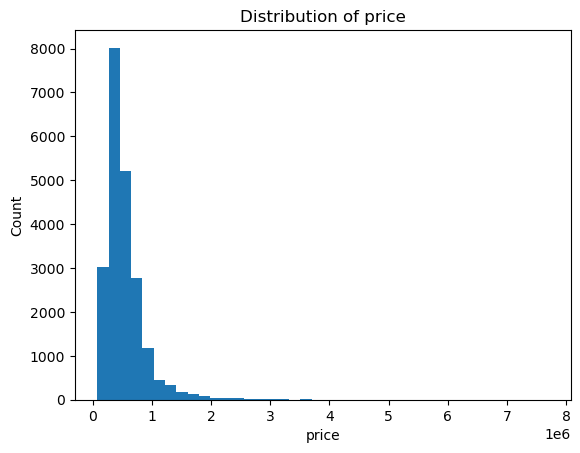

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64


In [6]:
y = df_fe[target].dropna()

plt.figure()
plt.hist(y, bins=40)
plt.title(f"Distribution of {target}")
plt.xlabel(target)
plt.ylabel("Count")
plt.show()

print(y.describe())

In [ ]:
# Correlations (numeric only)

,corr_with_target
price,1.000000
sqft_living,0.702035
grade,0.667434
sqft_above,0.605567
sqft_living15,0.585379
sqft_per_bedroom,0.580057
bathrooms,0.525885
view,0.397293
sqft_basement,0.323816
bedrooms,0.308890


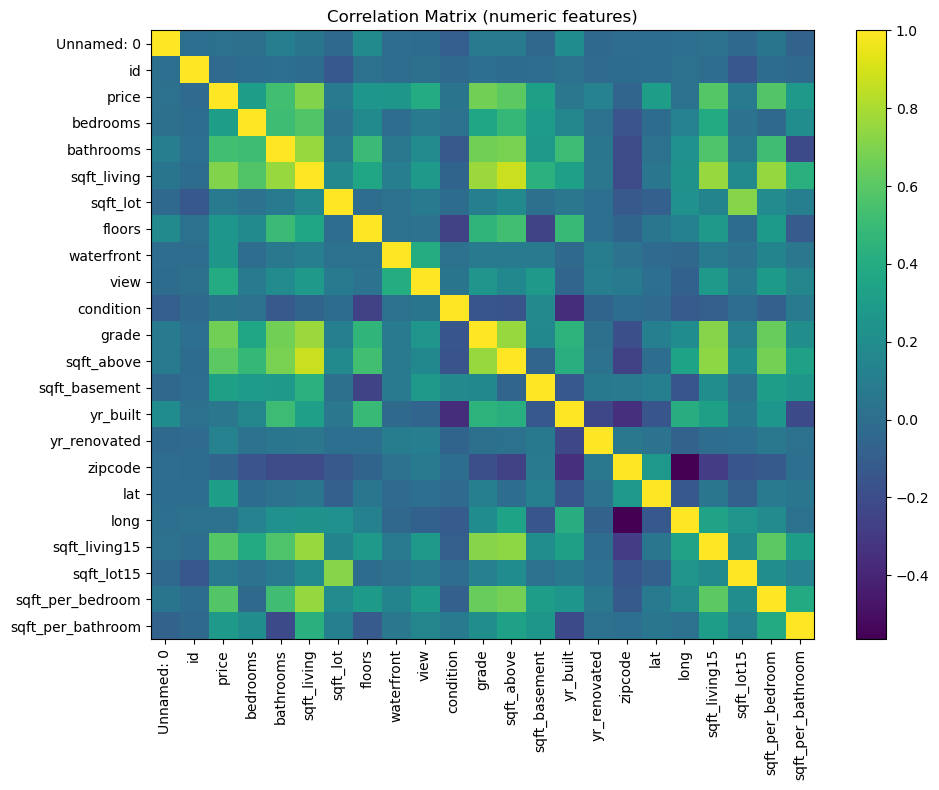

In [7]:
num_cols = df_fe.select_dtypes(include=[np.number]).columns.tolist()

if target in num_cols:
    corr_to_target = df_fe[num_cols].corr(numeric_only=True)[target].sort_values(ascending=False)
    display(corr_to_target.to_frame("corr_with_target"))

    corr_mat = df_fe[num_cols].corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    plt.imshow(corr_mat, aspect="auto")
    plt.title("Correlation Matrix (numeric features)")
    plt.xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=90)
    plt.yticks(range(len(corr_mat.index)), corr_mat.index)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [ ]:
# Key bivariate plots (adjust if columns exist)

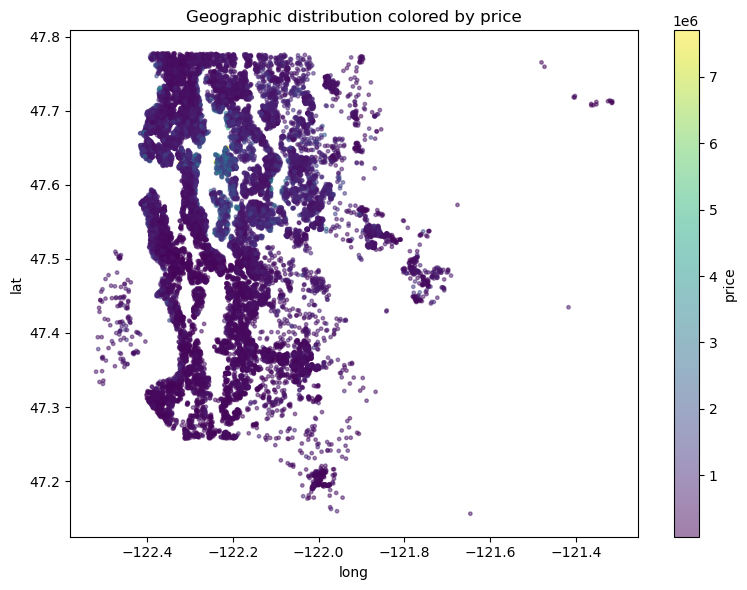

In [8]:
for xcol in ["median_income", "income"]:
    if xcol in df_fe.columns:
        plt.figure()
        plt.scatter(df_fe[xcol], df_fe[target], s=8, alpha=0.5)
        plt.title(f"{target} vs {xcol}")
        plt.xlabel(xcol)
        plt.ylabel(target)
        plt.show()
        break
# Geo plot if lat/long exist (your file has lat/long)
if "long" in df_fe.columns and "lat" in df_fe.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_fe["long"], df_fe["lat"], s=6, alpha=0.5, c=df_fe[target])
    plt.title(f"Geographic distribution colored by {target}")
    plt.xlabel("long")
    plt.ylabel("lat")
    plt.colorbar(label=target)
    plt.tight_layout()
    plt.show()

In [ ]:
# Train/test split + preprocessing pipeline

In [9]:
X = df_fe.drop(columns=[target])
y = df_fe[target]

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Numeric features: ['Unnamed: 0', 'id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_per_bedroom', 'sqft_per_bathroom']
Categorical features: ['date']


In [ ]:
# Baseline Linear Regression + Ridge (comparison table)

In [11]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=42),
}

results = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    rmse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2})

results_df = pd.DataFrame(results).sort_values("RMSE")
results_df

,Model,RMSE,MAE,R2
1,Ridge(alpha=1.0),4.513181e+10,128095.641015,0.701463
0,LinearRegression,4.519704e+10,128222.264476,0.701032


In [ ]:
# PCA + KMeans clustering (FAST: use subsample)

Explained variance ratio (PC1, PC2): [0.26390692 0.11132925]


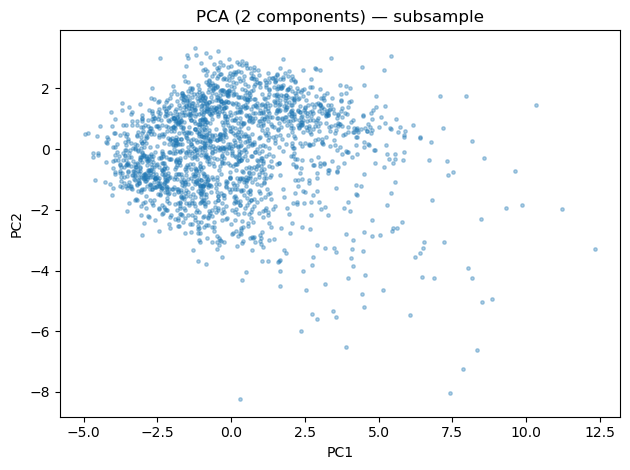

/lib/python3.13/site-packages/threadpoolctl.py:1123: RuntimeWarning: JsProxy.as_object_map() is deprecated. Use as_py_json() instead.
  for filepath in LDSO.loadedLibsByName.as_object_map():


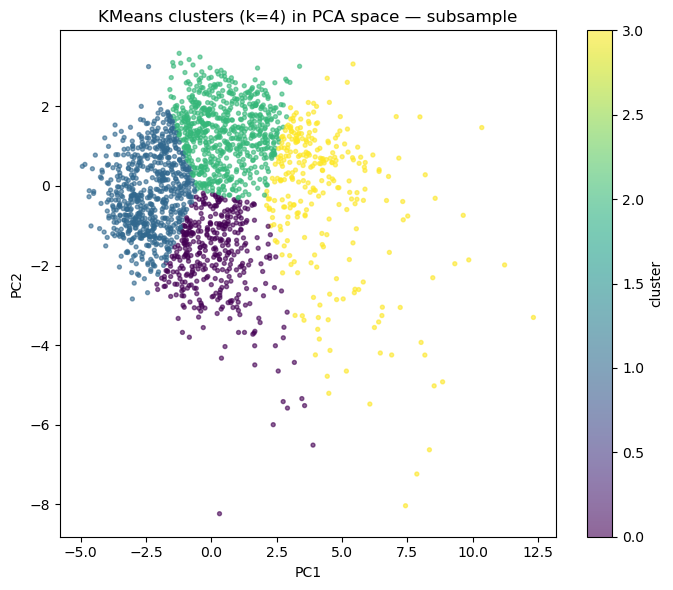

,count,mean,median,min,max
cluster,,,,,
0,387,662494.72,635000.0,178000.0,1900000.0
1,677,356986.61,330000.0,82500.0,1050000.0
2,652,464258.22,430000.0,139500.0,1388000.0
3,284,1059455.17,852500.0,274975.0,5350000.0


In [12]:
# Unsupervised EDA is for pattern discovery, not prediction accuracy.
sample_n = min(2000, len(df_fe))
idx = np.random.RandomState(42).choice(len(df_fe), size=sample_n, replace=False)
df_s = df_fe.iloc[idx].copy()

num_cols_s = df_s.select_dtypes(include=[np.number]).columns.tolist()
pca_features = [c for c in num_cols_s if c != target]

Z = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
]).fit_transform(df_s[pca_features])

pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Z)

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

plt.figure()
plt.scatter(Z2[:, 0], Z2[:, 1], s=6, alpha=0.35)
plt.title("PCA (2 components) — subsample")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# KMeans (choose k=4 as a practical default; adjust after elbow if you want)
k = 4
clusters = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(Z2)

plt.figure(figsize=(7, 6))
plt.scatter(Z2[:, 0], Z2[:, 1], s=8, alpha=0.6, c=clusters)
plt.title(f"KMeans clusters (k={k}) in PCA space — subsample")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="cluster")
plt.tight_layout()
plt.show()

# Cluster summary by target (price)
summary = (
    pd.DataFrame({"cluster": clusters, target: df_s[target].values})
      .groupby("cluster")[target]
      .agg(["count", "mean", "median", "min", "max"])
      .round(2)
)
summary


In [ ]:
# Clusters on map (subsample)

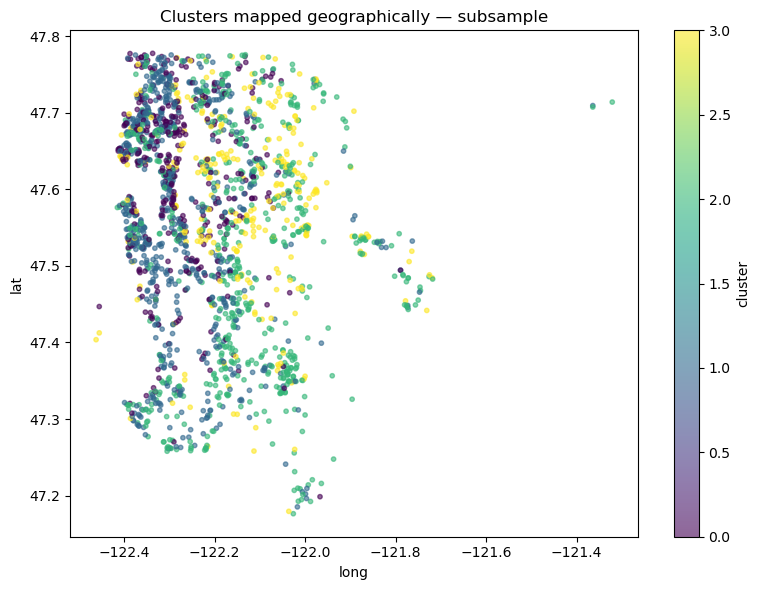

In [13]:
if "long" in df_s.columns and "lat" in df_s.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_s["long"], df_s["lat"], s=10, alpha=0.6, c=clusters)
    plt.title("Clusters mapped geographically — subsample")
    plt.xlabel("long")
    plt.ylabel("lat")
    plt.colorbar(label="cluster")
    plt.tight_layout()
    plt.show()
